# AIPI 590 - XAI | Assignment #06
## Mechanistic Interpretability
## Shaunak Badani

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shaunak-badani/XAI/blob/main/Assignment06/MechanisticInterpretability.ipynb)

> This notebook goes over a demo of the superposition hypothesis in the field of Mechanistic Interpretability

In [1]:
!pip install einops


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import trange

import time
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

## Synthetic data generation

- For this notebook, we generate synthetic data, which contains 5 features, and a hidden layer of size 2.
- For each batch, we consider 10 feature vectors generated in this 5 dimensional space

In [3]:
n_features = 5
n_hidden = 2
n_instances = 10

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [5]:
W = nn.Parameter(torch.empty((n_instances, n_features, n_hidden), device=device))

In [6]:
print(W.max(), W.min())

tensor(-0.3725, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.3725, device='cuda:0', grad_fn=<MinBackward1>)


- We initialize the weight matrix with a xavier normal distribution in the following cell:

In [7]:
_ = nn.init.xavier_normal_(W)
print(W.min(), W.max())

tensor(-0.6962, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4570, device='cuda:0', grad_fn=<MaxBackward1>)


In [8]:
b_final = nn.Parameter(torch.zeros((n_instances, n_features), device=device))

- Not every feature is given importance.
- In the real world analogy, dog ears may be more important than paws, so each feature is given a corresponding importance in this synthetic dataset.

In [9]:
importance = (0.9**torch.arange(n_features, device = device))[np.newaxis, :]

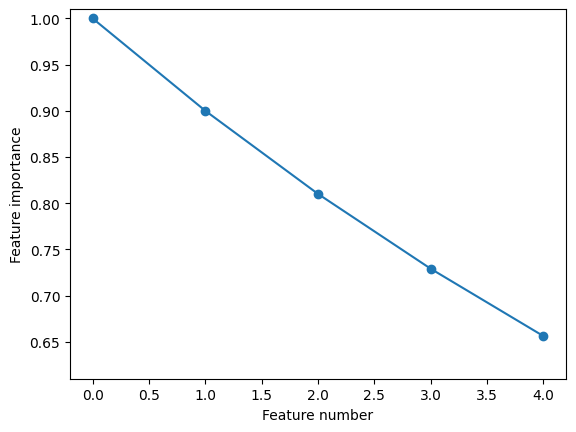

In [12]:
plt.plot(importance.detach().cpu().squeeze())
plt.ylim([0.61, 1.01])
plt.xlabel('Feature number')
plt.ylabel('Feature importance')
plt.scatter(torch.arange(n_features), importance.detach().cpu().squeeze())

In [13]:
feature_probability = (20 ** -torch.linspace(0, 1, n_instances, device = device))[:, None]

- For each instance, we calculate the importance of the instance.
- This importance vector comes in handy while calculating the loss for training our small model.
- Each feature vector's L2 reconstruction loss is multiplied with the corresponding importance, and the sum is taken, to obtain the final loss.

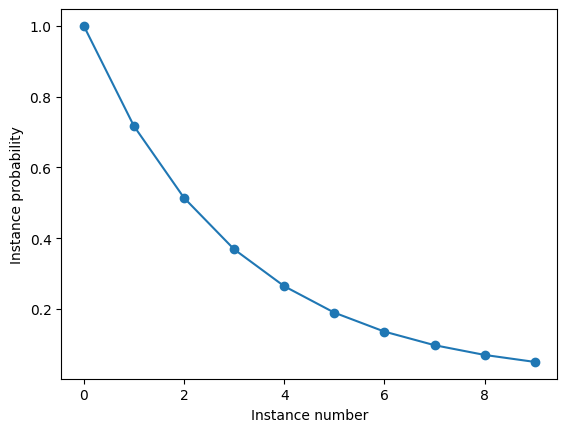

In [15]:
plt.plot(feature_probability.detach().cpu().squeeze())
# plt.ylim([0.61, 1.01])
plt.xlabel('Instance number')
plt.ylabel('Instance probability')
plt.scatter(torch.arange(n_instances), feature_probability.detach().cpu().squeeze())

## Model

- The model contains a simple architecture:
  - A linear layer which reduces dimensions (without bias)
  - A linear layer with the same weight as the previous, but transposed
  - This transforms the vector into 5-dimensional space again.
  - A bias is added followed by ReLU
  - The activation function helps learn more features than there are neurons

In [16]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.W = nn.Parameter(torch.empty((n_instances, n_features, n_hidden), device=device))
        _ = nn.init.xavier_normal_(self.W)
        self.b = nn.Parameter(torch.zeros((n_instances, n_features), device=device))
        self.feature_importance = importance
        self.feature_probability = feature_probability

    def forward(self, x):
        hidden = torch.einsum("...if,ifh->...ih", x, self.W)
        out = torch.einsum("...ih,ifh->...if", hidden, self.W)
        out = out + self.b
        out = F.relu(out)
        return out
model = Model()

In [17]:
feature_probability.shape

torch.Size([10, 1])

In [18]:
def generate_batch(n_batch):
    feat = torch.rand((n_batch, n_instances, n_features), device=device)
    batch = torch.where(
        torch.rand((n_batch, n_instances, n_features), device=device) <= feature_probability,
        feat,
        torch.zeros((), device=device),
    )
    return batch
test_batch = generate_batch(1)
print(test_batch.shape)

torch.Size([1, 10, 5])


Text(0.5, 1.0, 'A heatmap of 10 feature vectors, each 5-dimensional')

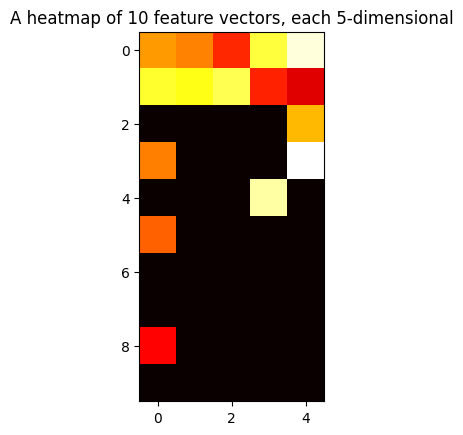

In [28]:
plt.imshow(test_batch.squeeze().cpu().detach(), cmap = 'hot')
plt.title("A heatmap of 10 feature vectors, each 5-dimensional")

- The above vectors were generated keeping in mind that data passed to models is usually sparse, and hence the sparsity assumption was maintained in the field

In [20]:
optimizer = torch.optim.AdamW(list(model.parameters()), lr=1e-3)

- Below is a figure outlining the 5 features mapped in 2 dimensional space

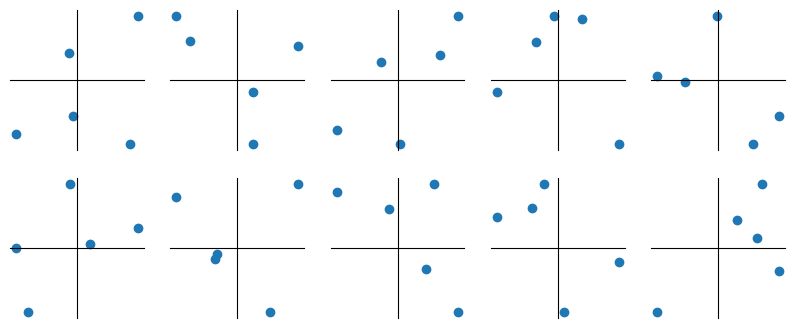

In [21]:
K, N, _ = W.shape
w = W.detach().cpu().numpy()

fig, axes = plt.subplots(2, K // 2, figsize = (K, 4), subplot_kw = {'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flatten()):
    ax.scatter(w[i, :, 0], w[i, :, 1])
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom','left']:
        ax.spines[spine].set_position('center')

In [25]:
for step in np.arange(1000):
  optimizer.zero_grad(set_to_none=True)
  batch = generate_batch(1024)
  out = model(batch)
  error = (importance*(batch.abs() - out)**2)
  loss = einops.reduce(error, 'b i f -> i', 'mean').sum()
  loss.backward()
  optimizer.step()

Determinant : 8.5790676e-26
Determinant : 2.6658512e-25
Determinant : -1.6888552e-25
Determinant : -1.1205561e-24
Determinant : 1.2398169e-24
Determinant : -8.0211124e-23
Determinant : 5.554154e-24
Determinant : 1.4538698e-22
Determinant : -2.1849262e-23
Determinant : -1.5238715e-22


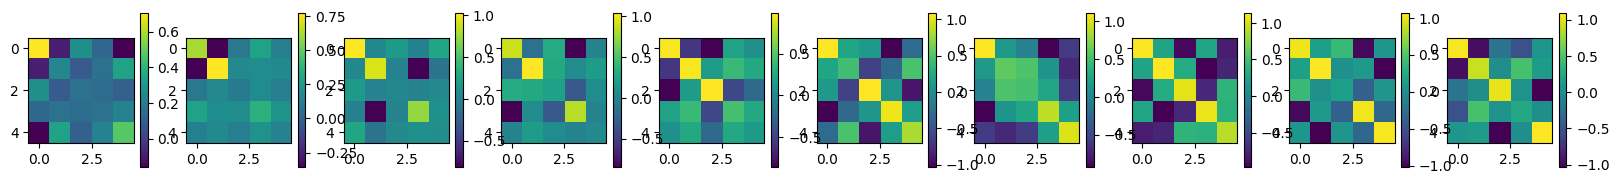

In [26]:
def plot_intro_diagram(model):
  from matplotlib import colors  as mcolors
  from matplotlib import collections  as mc
  WA = model.W.detach()
  sel = range(n_instances) # can be used to highlight specific sparsity levels
  fig, axs = plt.subplots(1,len(sel), figsize=(2*len(sel),2))
  for i, ax in zip(sel, axs):
      W = WA[i].cpu().detach().numpy()
      im = ax.imshow(W @ W.T)
      print("Determinant :", np.linalg.det(W @ W.T))
      plt.colorbar(im, ax = ax)
  plt.show()

plot_intro_diagram(model)

- As can be seen, the determinant of each $W^T W$ is close to 0, which implies it is non invertible.
- Hence, the superposition hypothesis holds true that the model is encompassing more features than the number of neurons it contains

### AI Usage

- No AI was used for any of the code written in this notebook.
- AI was used to understand the einstein summations that were part of the demo notebook, which helped get a grasp of the equivalent vector operations that we usually come across